# Assessing correctness of zod_frames_index

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image


df = pd.read_parquet("~/multimodal-MoE/outputs/index/ZODmoe_frames.parquet")

df.shape


(99999, 31)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   frame_id               99999 non-null  object 
 1   time                   99999 non-null  object 
 2   image_path             99999 non-null  object 
 3   resized_image_path     99999 non-null  object 
 4   orig_w                 99999 non-null  int64  
 5   orig_h                 99999 non-null  int64  
 6   new_w                  99999 non-null  int64  
 7   new_h                  99999 non-null  int64  
 8   sx                     99999 non-null  float64
 9   sy                     99999 non-null  float64
 10  scraped_weather        99999 non-null  object 
 11  time_of_day            99999 non-null  object 
 12  solar_angle_elevation  99999 non-null  float64
 13  country_code           99999 non-null  object 
 14  road_type              99999 non-null  object 
 15  ro

In [5]:
""" Note that for bin_4:
    - 0: no pedestrians
    - 1: 1-5 pedestrians
    - 2: 6-15 pedestrians
    - 3: >15 pedestrians
    - we can also define pedestrian presence 0 if bin_4 == 0, else 1. 
    """

df.head(5)




,frame_id,time,image_path,resized_image_path,orig_w,orig_h,new_w,new_h,sx,sy,...,ped_occ_heavy,ped_occ_veryheavy,ped_occ_missing,ped_occ_unknown,ped_uuid,ped_unclear_list,ped_occlusion_list,ped_points_xy_resized,ped_bin_4,ped_present
0,050000,2020-05-05T05:01:50.446218Z,/home/edgelab/zod_dino_data/train2017/050000/c...,/home/edgelab/zod_moe/resized_images/050000_dn...,3848,2168,1248,704,0.324324,0.324723,...,0,0,0,0,[e71868a7-575c-428d-bc62-a4d0a52dd3cc],[False],[none],"[[[608.1845092773438, 371.17828369140625], [60...",1,1
1,050001,2020-05-28T15:54:23.333153Z,/home/edgelab/zod_dino_data/train2017/050001/c...,/home/edgelab/zod_moe/resized_images/050001_dn...,3848,2168,1248,704,0.324324,0.324723,...,1,0,0,0,[98245ed7-7900-42b7-8083-c8654a344ae7],[False],[heavy],"[[[1004.4959716796875, 351.5929870605469], [10...",1,1
2,050002,2020-12-01T12:06:14.004010Z,/home/edgelab/zod_dino_data/train2017/050002/c...,/home/edgelab/zod_moe/resized_images/050002_dn...,3848,2168,1248,704,0.324324,0.324723,...,0,0,0,0,[ac4bbb2a-e2d5-4539-b90c-0817f77b822f],[False],[none],"[[[485.19744873046875, 355.79608154296875], [4...",1,1
3,050003,2020-04-14T07:24:35.996646Z,/home/edgelab/zod_dino_data/train2017/050003/c...,/home/edgelab/zod_moe/resized_images/050003_dn...,3848,2168,1248,704,0.324324,0.324723,...,0,1,0,0,[542c7ca6-f69f-4730-845e-b22338946402],[False],[veryheavy],"[[[497.6205139160156, 361.364990234375], [501....",1,1
4,050004,2021-04-15T10:16:19.993984Z,/home/edgelab/zod_dino_data/train2017/050004/c...,/home/edgelab/zod_moe/resized_images/050004_dn...,3848,2168,1248,704,0.324324,0.324723,...,2,0,3,0,"[01f350ee-d688-4ce0-af45-99248cc9cce4, 349f1e4...","[False, True, False, True, False, False, False...","[light, missing, heavy, missing, heavy, light,...","[[[254.15997314453125, 355.1043701171875], [26...",1,1


In [11]:
df.describe()

,orig_w,orig_h,new_w,new_h,sx,sy,solar_angle_elevation,ped_count_clear,ped_count_unclear,ped_occ_none,ped_occ_light,ped_occ_medium,ped_occ_heavy,ped_occ_veryheavy,ped_occ_missing,ped_occ_unknown,ped_bin_4,ped_present
count,99999.0,99999.0,99999.0,99999.0,9.999900e+04,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.0,99999.000000,99999.000000
mean,3848.0,2168.0,1248.0,704.0,3.243243e-01,0.324723,20.067651,3.185832,0.405954,1.008300,0.933139,0.538265,0.506905,0.199222,0.405954,0.0,0.802498,0.575786
std,0.0,0.0,0.0,0.0,1.665343e-16,0.000000,25.078587,5.378451,1.339227,1.818933,1.888296,1.332962,1.408222,0.732708,1.339227,0.0,0.825643,0.494226
min,3848.0,2168.0,1248.0,704.0,3.243243e-01,0.324723,-57.703828,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,3848.0,2168.0,1248.0,704.0,3.243243e-01,0.324723,2.651154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,3848.0,2168.0,1248.0,704.0,3.243243e-01,0.324723,22.974942,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000
75%,3848.0,2168.0,1248.0,704.0,3.243243e-01,0.324723,40.570388,4.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000
max,3848.0,2168.0,1248.0,704.0,3.243243e-01,0.324723,65.486513,127.000000,84.000000,36.000000,39.000000,47.000000,50.000000,21.000000,84.000000,0.0,3.000000,1.000000


In [4]:
#Now we pull from parquete file to check the new column
df1 = pd.read_parquet("~/multimodal-MoE/outputs/index/zod256_frames.parquet")
df1.head()



,frame_id,time,image_path,scraped_weather,time_of_day,solar_angle_elevation,country_code,road_type,road_condition,ped_count_clear,ped_count_unclear,ped_occ_none,ped_occ_light,ped_occ_medium,ped_occ_heavy,ped_occ_veryheavy,ped_occ_unknown,ped_bin_4,ped_presence
0,050000,2020-05-05T05:01:50.446218Z,/mnt/pr_2018_scaleout_workdir/ZOD256/single_fr...,partly-cloudy-day,day,16.170558,SE,city,normal,1,0,1,0,0,0,0,0,1,1
1,050001,2020-05-28T15:54:23.333153Z,/mnt/pr_2018_scaleout_workdir/ZOD256/single_fr...,cloudy,day,27.834328,SE,city,normal,1,0,0,0,0,1,0,0,1,1
2,050002,2020-12-01T12:06:14.004010Z,/mnt/pr_2018_scaleout_workdir/ZOD256/single_fr...,rain,day,15.790678,DE,city,wet,1,0,1,0,0,0,0,0,1,1
3,050003,2020-04-14T07:24:35.996646Z,/mnt/pr_2018_scaleout_workdir/ZOD256/single_fr...,clear-day,day,28.634695,DE,city,normal,1,0,0,0,0,0,1,0,1,1
4,050004,2021-04-15T10:16:19.993984Z,/mnt/pr_2018_scaleout_workdir/ZOD256/single_fr...,rain,day,47.714986,PL,city,wet,5,3,0,3,0,2,0,3,1,1


In [ ]:
#Label distribution (excluding unclear pedestrians from the count)
df["ped_bin_4"].value_counts().sort_index()



ped_bin_4
0    42421
1    38395
2    15695
3     3488
Name: count, dtype: int64

In [17]:

df["ped_count_clear"].describe(), df["ped_count_unclear"].describe()
# we see below that there are far more clear pedestrians on average (3.18) than unclear pedestrians (0.41)


(count    99999.000000
 mean         3.185832
 std          5.378451
 min          0.000000
 25%          0.000000
 50%          1.000000
 75%          4.000000
 max        127.000000
 Name: ped_count_clear, dtype: float64,
 count    99999.000000
 mean         0.405954
 std          1.339227
 min          0.000000
 25%          0.000000
 50%          0.000000
 75%          0.000000
 max         84.000000
 Name: ped_count_unclear, dtype: float64)

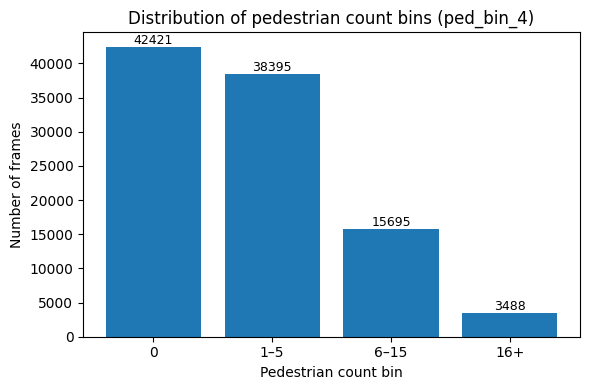

In [18]:
#HISTOGRAM OF PEDESTRIAN COUNT BINS
counts = df["ped_bin_4"].value_counts().sort_index()

plt.figure(figsize=(6,4))
bars = plt.bar(range(4), counts.values)

plt.xlabel("Pedestrian count bin")
plt.ylabel("Number of frames")
plt.title("Distribution of pedestrian count bins (ped_bin_4)")
plt.xticks(range(4), ["0", "1–5", "6–15", "16+"])

for i, v in enumerate(counts.values):
    plt.text(i, v, f"{v}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


### Weather distribution

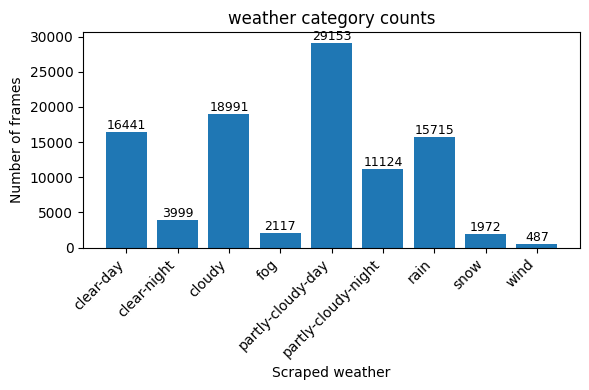

In [ ]:
counts = df["scraped_weather"].value_counts().sort_index()

plt.figure(figsize=(6, 4))
bars = plt.bar(range(len(counts)), counts.values)

plt.xlabel("Scraped weather")
plt.ylabel("Number of frames")
plt.title('weather category counts')
plt.xticks(range(len(counts)), counts.index, rotation=45, ha="right")

for i, v in enumerate(counts.values):
    plt.text(i, v, f"{v}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

In [19]:
#Checking for missing values in the metadata
df[["scraped_weather","time_of_day","solar_angle_elevation","road_type","road_condition"]].isna().mean().sort_values(ascending=False)



scraped_weather          0.0
time_of_day              0.0
solar_angle_elevation    0.0
road_type                0.0
road_condition           0.0
dtype: float64

In [20]:
sample = df.sample(20, random_state=0)
missing = [p for p in sample["image_path"] if not Path(p).exists()]
len(missing), missing[:3]


(0, [])

In [21]:
occ_sum = df[["ped_occ_none","ped_occ_light","ped_occ_medium","ped_occ_heavy","ped_occ_veryheavy","ped_occ_unknown"]].sum(axis=1)
bad = (occ_sum > (df["ped_count_clear"] + df["ped_count_unclear"])).sum()
bad


np.int64(0)

In [22]:
# Bins by time of day
pd.crosstab(df["time_of_day"], df["ped_bin_4"])


ped_bin_4,0,1,2,3
time_of_day,,,,
day,26082,33172,14774,3318
night,14363,4041,521,81
twilight,1976,1182,400,89


In [23]:
#Bins by weather condition
pd.crosstab(df["scraped_weather"], df["ped_bin_4"])

ped_bin_4,0,1,2,3
scraped_weather,,,,
clear-day,5818,7283,2740,600
clear-night,2959,840,171,29
cloudy,7269,7139,3670,913
fog,1415,552,131,19
partly-cloudy-day,8276,13294,6178,1405
partly-cloudy-night,7451,3003,563,107
rain,7843,5525,1985,362
snow,1036,686,220,30
wind,354,73,37,23


In [24]:
#Bins by road type
pd.crosstab(df["road_type"], df["ped_bin_4"])

ped_bin_4,0,1,2,3
road_type,,,,
arterial-rural,9156,727,38,4
arterial-urban,11123,8940,3029,710
city,7311,27444,12537,2769
highway,10861,191,8,1
smaller-rural,3970,1093,83,4


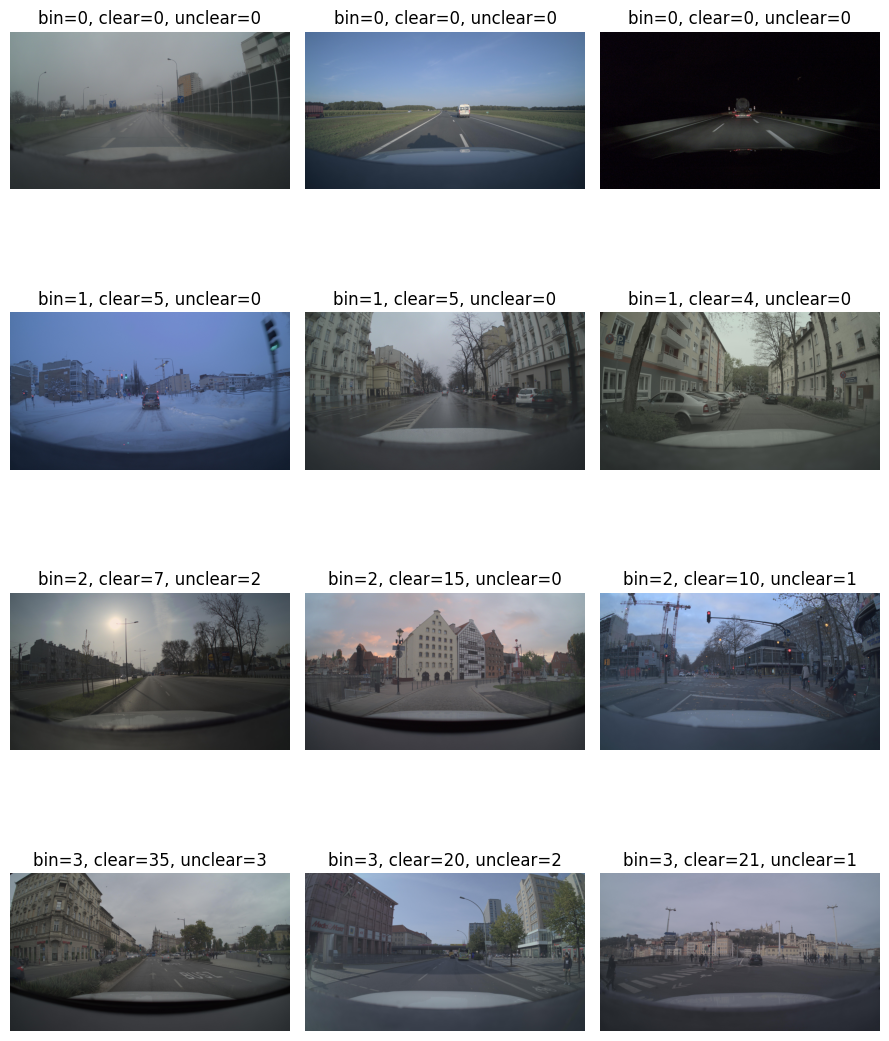

In [25]:
from PIL import Image

bins = [0,1,2,3]
fig, axes = plt.subplots(4, 3, figsize=(9, 12))

for i, b in enumerate(bins):
    sub = df[df["ped_bin_4"] == b].sample(3, random_state=1)
    for j, (_, r) in enumerate(sub.iterrows()):
        img = Image.open(r["image_path"]).convert("RGB")
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"bin={b}, clear={r['ped_count_clear']}, unclear={r['ped_count_unclear']}")
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()


Frame ID: 050002
Image path: /home/edgelab/zod_moe/resized_images/050002_dnat.jpg
Number of pedestrians: 1


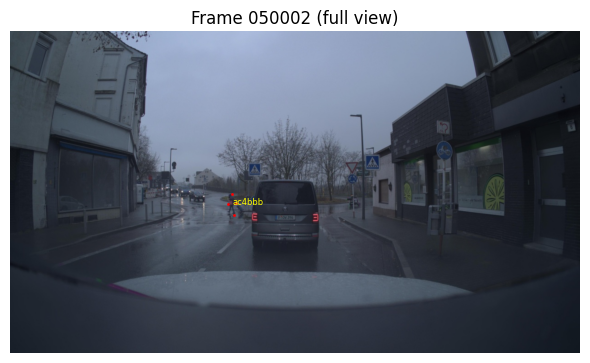

In [ ]:
"""NOTE: for a given keyframe (row in the df),
the following all refer to the same pedestrian: 
row["ped_points_xy_resized"][i]
row["ped_uuid"][i]
row["ped_unclear_list"][i]
row["ped_occlusion_list"][i]"""

# Select a frame with at least one pedestrian
row = df[df["ped_count_clear"] > 0].iloc[2]

print("Frame ID:", row["frame_id"])
print("Image path:", row["resized_image_path"])
print("Number of pedestrians:", len(row["ped_points_xy_resized"]))

# Load resized image
img = Image.open(row["resized_image_path"]).convert("RGB")
img_np = np.array(img)

# Plot full image
plt.figure(figsize=(6, 4))
plt.imshow(img_np)

# Loop over pedestrians and plot multipoints
for i, ped_points in enumerate(row["ped_points_xy_resized"]):
    
    # Convert from (4,) of (2,) arrays → proper (4,2) matrix
    coords = np.vstack(ped_points).astype(np.float32)
    
    # Plot the 4 corner points
    plt.scatter(coords[:, 0], coords[:, 1], c="red", s=1)
    
    # label with UUID (first 6 chars for readability)
    uuid = row["ped_uuid"][i]
    center_x = coords[:, 0].mean()
    center_y = coords[:, 1].mean()
    plt.text(center_x, center_y, uuid[:6], color="yellow", fontsize=6)

plt.title(f"Frame {row['frame_id']} (full view)")
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
row = df.iloc[0]
print("Type of ped_points_xy_resized:", type(row["ped_points_xy_resized"]))
print("Length:", len(row["ped_points_xy_resized"]))

if len(row["ped_points_xy_resized"]) > 0:
    first = row["ped_points_xy_resized"][0]
    print("\nType of first element:", type(first))
    print("As numpy array shape:", np.asarray(first).shape)
    print("Raw first element:", first)




Type of ped_points_xy_resized: <class 'numpy.ndarray'>
Length: 1

Type of first element: <class 'numpy.ndarray'>
As numpy array shape: (4,)
Raw first element: [array([608.18450928, 371.17828369]) array([609.77972412, 376.11572266])
 array([608.18450928, 380.44396973]) array([606.01135254, 375.81115723])]


ValueError: setting an array element with a sequence.

In [ ]:
frame_id = "000000"
coordinates = df.loc[df["frame_id"] == frame_id, "ped_points_xy_resized"].values[0]



In [43]:
# We need to convert the ped_points_xy_resized from 
# a (4,) array of (2,) arrays to a canonical xyxy bounding box
# that can be later processed to the formats required by YOLO and DINO architectures
#print(coordinates) # This is a list of arrays, each shape (4,) with elements that are also arrays of shape (2,)

# Get one element (one bounding box)
one_bbox = coordinates[0]
print(type(one_bbox))
print(one_bbox.shape)
print(one_bbox[0].shape)
print(one_bbox)





<class 'numpy.ndarray'>
(4,)
(2,)
[array([522.21405029, 357.98141479]) array([523.92321777, 361.11175537])
 array([522.43780518, 367.88546753]) array([520.35565186, 361.11175537])]


In [ ]:
# Convert to xyxy format
# Convert from (4,) of (2,) arrays → proper (4,2) matrix
coords = np.vstack(one_bbox).astype(np.float32)
min_x = np.min(coords[:, 0])
min_y = np.min(coords[:, 1])
max_x = np.max(coords[:, 0])
max_y = np.max(coords[:, 1])
xyxy = [min_x, min_y, max_x, max_y]
print(xyxy)

def convert_coords_to_xyxy(coords):
    """
    Convert a (4,) array of (2,) arrays to a canonical xyxy bounding box. 
    This representation is Framework-agnostic, can convert to other formats expected
    by YOLO and DINO architectures easily. 
    """
    coords = np.vstack(coords).astype(np.float32)
    min_x = np.min(coords[:, 0])
    min_y = np.min(coords[:, 1])
    max_x = np.max(coords[:, 0])
    max_y = np.max(coords[:, 1])
    return [min_x, min_y, max_x, max_y]